<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Chemistry Simulations of NH₃ using VQE with a UCCSD ansatz**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_5000.png)

<font color="blue">Let us simulates a quantum chemistry algorithm (VQE) using CUDA-Q as well as Pennylane on GPUs, targeting the ground state energy of NH₃ via a variational quantum eigensolver (VQE) with a UCCSD ansatz and a classical optimizer (COBYLA). I will demonstrate this im three steps:
* **Step 1**: (Pyscf) Classical Computational Chemistry Simulation of Ground State Energy of NH₃
* **Step 2**: (Cuda-Q) Single GPU - Quantum Simulation of Ground State Energy for NH₃
* **Step: 3**: (Cuda-Q) Multi-GPU / Multi-Node- Quantum Simulation of Ground State Energy for NH₃
* **Step: 4:** (Pennylane) Multi-GPU / Multi-Node- Quantum Simulation of Ground State Energy for NH₃

For the two last steps I will go into more detail on how we determine the right number of GPUs, the optimal number of Qubits to simulate, and the proper distribution strategy based on the chemical properties and the task of ground state energy calculations.

#### **Libraries and Setup**

In [ ]:
# Check access to nvidia GPUs
!nvidia-smi

Mon May 26 14:30:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   60C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


Check which NumPy is installed. One of the dependencies of CUDA-Q is trying to use 'np.string_' which was removed in NumPy 2.0, and you will get an error later *AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_`*. We need to downgrade np.

In [ ]:
# Force install NumPy < 2.0
!pip install numpy==1.26.4 --force-reinstall -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


<font color="blue">Important: After installing, you **MUST restart the kernel/runtime before running the code.**

In [ ]:
# Automatically restart runtime after package installation
import os
if "COLAB_GPU" in os.environ:
    print("Restarting runtime to ensure clean package environment...")
    os.kill(os.getpid(), 9)

In [ ]:
# Alternative: More explicit restart
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import numpy as np
print(np.__version__)  # Should show 1.26.4

1.26.4


In [ ]:
!pip install openfermionpyscf==0.5 matplotlib==3.8.4 scipy==1.14.0 -q
import matplotlib.pyplot as plt
from scipy.optimize import minimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.2 MB/s eta 0:00:00


In [ ]:
!pip install cudaq -q
import cudaq
print(cudaq.__version__)
!pip show cudaq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 6.3 MB/s eta 0:00:00
CUDA-Q Version 0.11.0 (https://github.com/NVIDIA/cuda-quantum f5cc3bb1d85abcf1f642f4ddd20ad08bc1d4d200)
Name: cudaq
Version: 0.11.0
Summary: Python bindings for the CUDA-Q toolkit for heterogeneous quantum-classical workflows.
Home-page: https://developer.nvidia.com/cuda-q
Author: NVIDIA Corporation & Affiliates
Author-email: 
License: Apache License Version 2.0

Copyright (c) 2023 - 2025 N

In [ ]:
# Classical Quantum Chemistry
!pip install pyscf geometric -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### <font color="blue">**Step 1: PySCF Classical Computational Chemistry Simulation of Ground State Energy of NH₃**

Let us start with a standard computational chemistry calculation as a benchmark. We will notice slightly different results when using Restricted Hartree Fock with UCCSD (as classical algorithms) compared to Variational Quantum Eigensolver.

In [ ]:
# Define molecule
mol = gto.Mole()
mol.atom = '''
    N  0.0000  0.0000  0.2000
    H  0.0000  0.9433 -0.2000
    H  0.8165 -0.4717 -0.2000
    H -0.8165 -0.4717 -0.2000
'''

# Name
molecule = 'Ammonia (NH₃)'

In [ ]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'cc-pvdz' # Alternative basis set: sto-3g, cc-pvdz,6-31G
mol.symmetry = False  # Set false, otherwise geometry optimization doesnt work
mol.spin = 0          # Ammonia is a stable, closed-shell molecule with a lone pair on the nitrogen and three N-H bonds. All electrons are paired.
# All valence electrons are paired (8 valence electrons total, including the lone pair on nitrogen). Ground state is a singlet. mol.spin = 0 (since S=0, 2S=0)
mol.build()

In [ ]:
print("-" * 20)
print(f"{molecule} molecule symmetry:")
print(f" Top group: {mol.topgroup}")
print(f" Group name: {mol.groupname}")
print("-" * 20)

--------------------
Ammonia (NH₃) molecule symmetry:
 Top group: C1
 Group name: C1
--------------------


In [ ]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -56.1950297883987


np.float64(-56.19502978839872)

converged SCF energy = -56.1950297883987


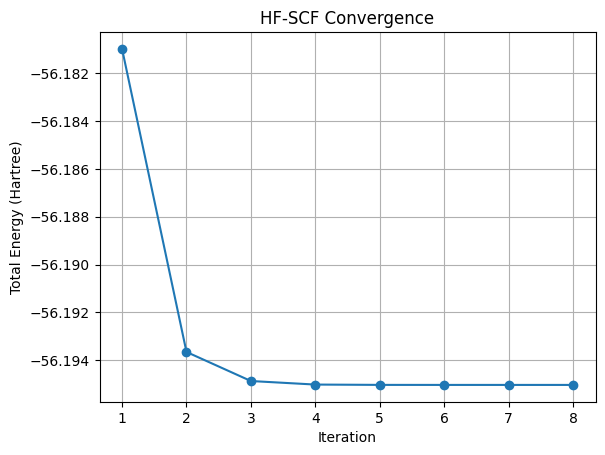

Ground state energy for Ammonia (NH₃): -56.195029788398664 Hartree


In [ ]:
# Visualization of calculation process (Hartree-Fock)
mf = scf.RHF(mol)                         # Set method
conv_data = []                            # Store convergence data
def callback(envs):                       # Callback function to collect convergence information
    conv_data.append(envs['e_tot'])       # Captures energy values at each iteration to track process
mf.callback = callback                    # Set callback directly on the mf object
energy_classical = mf.kernel()                      # Perform HF calculation
energies = conv_data                      # Extract energy values
iterations = range(1, len(energies) + 1)  # Extract iteration numbers
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title('HF-SCF Convergence')
plt.grid(True)
plt.show()
print(f"Ground state energy for {molecule}: {energy_classical} Hartree")

In [ ]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()

converged SCF energy = -56.5541464333647


np.float64(-56.55414643336466)

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
mp2 = mp.MP2(mf) # MP2 single point energy calculation
energy_mp2 = mp2.kernel()
print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -56.1950297883988
E(MP2) = -56.3848880155787  E_corr = -0.189858227179928
E(SCS-MP2) = -56.3852405707761  E_corr = -0.190210782377339
MP2 energy: -0.18985822717992806 Hartree


In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()
ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
#print(f"HF-SCF energy: {hf_energy} Hartree")
#print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -56.1950297883988
E(CCSD) = -56.40099455939956  E_corr = -0.2059647710007919
CCSD(T) correction = -0.00392240499597009


In [ ]:
# Excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -56.1950297883988
Excited State energies (eV)
[ 8.4938025  10.41834095 10.41969605]

** Singlet excitation energies and oscillator strengths **
Excited State   1:      8.49380 eV    145.97 nm  f=0.0574
Excited State   2:     10.41834 eV    119.01 nm  f=0.0412
Excited State   3:     10.41970 eV    118.99 nm  f=0.0412


In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
mol_eq = optimize(mf)
print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-65b48336-517a-4781-91d6-596cc10ce599.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   0.000000   0.000000   0.200000    0.000000  0.000000  0.000000
   H   0.000000   0.943300  -0.200000    0.000000  0.000000  0.000000
   H   0.816500  -0.471700  -0.200000    0.000000  0.000000  0.000000
   H  -0.816500  -0.471700  -0.200000    0.000000  0.000000  0.000000
converged SCF energy = -56.1950297884009
--------------- RHF_Scanner gradients ---------------
         x                y                z
0 N     0.0000000000    -0.0001718168     0.0151838105
1 H    -0.0000000000     0.0140691947    -0.0051101976
2 H     0.0119131340    -0.0069486890    -0.0050368064
3 H    -0.0119131340    -0.0069486890    -0.0050368064
----------------------------------------------
cycle 1: E = -56.1950297884  dE = -56.195  norm(grad) = 0.0297622


Step    0 : Gradient = 1.488e-02/1.518e-02 (rms/max) Energy = -56.1950297884
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 4.36115e-01 4.36604e-01 4.36604e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.000000  -0.000032   0.199825   -0.000000 -0.000032 -0.000175
   H  -0.000000   0.923632  -0.199951   -0.000000 -0.019668  0.000049
   H   0.799998  -0.461850  -0.199937   -0.016502  0.009850  0.000063
   H  -0.799998  -0.461850  -0.199937    0.016502  0.009850  0.000063
converged SCF energy = -56.1956938748781
--------------- RHF_Scanner gradients ---------------
         x                y                z
0 N    -0.0000000000     0.0000304517     0.0007056769
1 H     0.0000000000    -0.0021675690    -0.0002264122
2 H    -0.0018252768     0.0010685587    -0.0002396323
3 H     0.0018252768     0.0010685587    -0.0002396323
----------------------------------------------
cycle 2: E = -56.1956938749  dE = -0.000664086  norm(grad) = 0.00378289


Step    1 : Displace = 1.677e-02/1.967e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.891e-03/2.179e-03 (rms/max) E (change) = -56.1956938749 (-6.641e-04) Quality = 0.868
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 4.36282e-01 4.36604e-01 4.87308e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.000000  -0.000024   0.194432   -0.000000  0.000008 -0.005393
   H  -0.000000   0.928427  -0.198151   -0.000000  0.004795  0.001800
   H   0.804068  -0.464251  -0.198141    0.004071 -0.002401  0.001796
   H  -0.804068  -0.464251  -0.198141   -0.004071 -0.002401  0.001796
converged SCF energy = -56.19573056252
--------------- RHF_Scanner gradients ---------------
         x                y                z
0 N     0.0000000000     0.0000007870     0.0006070516
1 H    -0.0000000000     0.0000686184    -0.0002021302
2 H     0.0000618068    -0.0000347027    -0.0002024607
3 H    -0.0000618068    -0.0000347027    -0.0002024607
----------------------------------------------
cycle 3: E = -56.1957305625  dE = -3.66876e-05  norm(grad) = 0.000711412


Step    2 : Displace = 5.159e-03/5.393e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 3.557e-04/6.071e-04 (rms/max) E (change) = -56.1957305625 (-3.669e-05) Quality = 1.096
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 4.36281e-01 4.36604e-01 5.30375e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   0.000000  -0.000023   0.193079    0.000000  0.000001 -0.001353
   H  -0.000000   0.928918  -0.197699    0.000000  0.000491  0.000451
   H   0.804488  -0.464498  -0.197690    0.000420 -0.000246  0.000451
   H  -0.804488  -0.464498  -0.197690   -0.000420 -0.000246  0.000451
converged SCF energy = -56.1957315403973
--------------- RHF_Scanner gradients ---------------
         x                y                z
0 N    -0.0000000000     0.0000002434     0.0000406553
1 H    -0.0000000000     0.0000204184    -0.0000134837
2 H     0.0000176042    -0.0000103309    -0.0000135858
3 H    -0.0000176042    -0.0000103309    -0.0000135858
----------------------------------------------
cycle 4: E = -56.1957315404  dE = -9.77877e-07  norm(grad) = 5.87712e-05


Step    3 : Displace = 8.882e-04/1.353e-03 (rms/max) Trust = 2.000e-01 (+) Grad = 2.939e-05/4.066e-05 (rms/max) E (change) = -56.1957315404 (-9.779e-07) Quality = 1.045
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 4.36281e-01 4.36604e-01 5.30375e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 1.022 seconds


[[ 2.11943727e-14 -4.28424586e-05  3.64866412e-01]
 [-4.68419658e-14  1.75540070e+00 -3.73597435e-01]
 [ 1.52026242e+00 -8.77773414e-01 -3.73579713e-01]
 [-1.52026242e+00 -8.77773414e-01 -3.73579713e-01]]


#### <font color="blue">**Step 2: Cuda-Q Single GPU - Quantum Simulation of Ground State Energy for NH₃**

Now we formulate our chemistry problem into a quantum algorithm and run it on a single GPU without any distribution strategy. We compare the ground state energy result with the precious classical computational method and we will monitor the time requires to compute the result. This code is takem from a [cuda-q tutorial](https://nvidia.github.io/cuda-quantum/0.7.1/examples/python/tutorials/vqe.html) for VQEs.

In [ ]:
###############################
# GPU backend for simulation
###############################

# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

In [ ]:
###############################
# Molecule and Basis Set
###############################

# Number of hydrogen atoms.
hydrogen_count = 2

# Define ammonia molecule
geometry = [
    ["N", (0.0000, 0.0000, 0.0000)], # Nitrogen
    ["H", (0.0000, 0.0000, 1.0120)], # Hydrogen 1
    ["H", (0.9377, 0.0000, -0.3430)], # Hydrogen 2
    ["H", (-0.9377, 0.0000, -0.3430)] # Hydrogen 3
    ]

# We use STO-3G basis set and build the electronic Hamiltonian
molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
###############################
# Resource Requirements
###############################

# This is important to define the distribution strategy (# of GPUs and nodes)
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 10
Qubit count: 16
Number of orbitals: 8


In [ ]:
###############################
# Kernel and Ansatz (VQE)
###############################

# Quantum kernel prepares Hartree-Fock state by applying X gates to electrons and UCCSD ansatz with parameters thetas
# Unitary Coupled-Cluster Singles and Doubles (UCCSD) captures electronic correlations well, often used in quantum chemistry
# Alternatives: Nelder-Mead vs gradient-based etc

@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
###############################
# Optimizer
###############################

# COBYLA (Constrained Optimization BY Linear Approximations) for minimization of expected energy of molecule
# Gradient-free classical optimizer, well-suited for noisy landscapes (like those from VQE)

optimizer = cudaq.optimizers.COBYLA()

# 'cudaq.vqe' executes Variational Quantum Eigensolver (VQE)
# Internally loops over parameters, evaluates energy, optimizes. Returns lowest energy and optimal parameters
energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(f"VQE minimum energy for NH₃: {energy} Hartree")

VQE minimum energy for NH₃: -55.43534589340438 Hartree


Let us understand and compare the results: The VQE result of is in 'Hartree'. These are atomic units used for constructing the molecular Hamiltonian with the quantum chemistry backend `cudaq.chemistry.create_molecular_hamiltonian(...)`.

Even though we are doing a quantum variational calculation, the observable (the Hamiltonian) is derived from the same electronic structure Hamiltonian as classical Hartree-Fock SCF, which is typically expressed in Hartrees:

> $H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$

where $h_{pq}$, $h_{pqrs}$ are integrals in Hartree units.


In [ ]:
print(f"Quantum Simulation for NH₃: {energy} Hartree")
print(f"Classic Simulation for NH₃: {energy_classical} Hartree")
print(f"Correlation Energy for NH₃: {energy_classical - energy} Hartree (Classical - Quantum)")

The **classical simulation** is using 'Restricted Hartree-Fock (RHF)'. This is so-called a 'mean-field method' that uses a single Slater determinant to approximate the ground state. The result is:

> <font color="blue">$E_{\text{HF}} = -56.1956225560141 \ \text{Hartree}$

This approach ignores electron correlation beyond exchange interactions for computational efficiency.

The **quantum simulation** uses VQE with a UCCSD ansatz, which goes beyond Hartree-Fock, because it captures electron correlation by including excited Slater determinants in a variational way. This approximates so-called 'Full Configuration Interaction (FCI)' more closely and gives the more exact solution in the chosen basis. The result is:

> <font color="blue">$E_{\text{VQE}} \approx -55.43534589340438 \ \text{Hartree}$
* This is lower than the HF energy, as expected.

The difference of

> <font color="blue">$\Delta E = E_{\text{HF}} - E_{\text{VQE}} \approx -0.76027666261 \ \text{Hartree}$

**is the correlation energy captured by the UCCSD ansatz but missed by Hartree-Fock.** So the quantum result is more accurate, assuming the ansatz is expressive enough and optimization converges well.

Running a full configuration interaction (FCI) for comparison would give us the exact ground state energy in the basis set and confirm that the VQE is close to the true minimum.

> <font color="red">*More importantly: This calculation is going to take 1 hours if we proceed with our calculation from above on a single L4 GPU . This means we need to think how we distribute the calculation.*

#### <font color="blue">**Step 3: Cuda-Q Multi-GPU / Multi-Node- Quantum Simulation of Ground State Energy for NH₃**

'- - - *This still requires some final updates to work properly on GCP* - - - '

<font color="blue">*Overview of Resource Requirements*

We can speed up the calculation time by reducing the communication time from O(N²) to O(log N) by exploiting parallelization and using the ideal number of GPUs. **But how exactly do we determine the proper approach to distribute quantum simulation workload across how many GPUs and potentially nodes to speed up the calculation?**

We need to understand the task that we are running and the molecule we are analyzing. From there we can derive the number of terms and whether or not we can parallelize calculations.

Our use case is applying **Variational Quantum Eigensolvers** to calculate the **expectation value** of the **molecular Hamiltonian $H$** with respect to a parameterized quantum state $|\psi(\theta)\rangle$:

> $E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle$

The molecular Hamiltonian $H$ is represented in the **second quantized fermionic form**, which is then transformed (e.g., via **Jordan-Wigner** or **Bravyi-Kitaev**) into a **qubit Hamiltonian**:

> $H = \sum_i c_i P_i$

where:

* $c_i$ are scalar coefficients (from electronic integrals),
* $P_i$ are **tensor products of Pauli operators**: e.g., $Z \otimes I \otimes X \otimes Z \otimes \dots$

The number of these **Pauli strings** depends on:

* Number of **orbitals** (determines qubits),
* Symmetry of the system,
* Type of fermion-to-qubit transformation.

For **NH₃**, the system leads to **16 qubits**, and we will see that after transformation and grouping (via Hamiltonian simplification or symmetries), the Hamiltonian is decomposed into **156 distinct Pauli terms**. These are what we need to measure to reconstruct the energy, and these are the blocks that we need to distribute.

Thanks to the **observable parallelization** (Hamiltonian term) we can do these calculations all independently. This means that we will be using **8 GPUs and 1 node (machine)**. Before we get to the code on Google Cloud, let us dive a bit deeper on how we got to those numbers.

<font color="blue">*How many qubits do we need?*

[Ammonia](https://en.m.wikipedia.org/wiki/Ammonia) (NH₃) has a Trigonal pyramidal structure with three hydrogen atoms forming a triangular base:

![science](https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Ammoniak.svg/195px-Ammoniak.svg.png)

```
# Resource Requirements
print(f"Number of electrons: {electron_count}")
print(f"Number of orbitals: {data.n_orbitals}")
print(f"Number of qubits: {qubit_count}")

Number of electrons: 10
Number of orbitals: 8
Number of qubits: 16
```

*How the number of electrons and orbitals lead us to qubit count:*
* NH₃ has **10 valence electrons** (7 electrons from N and 1 from each H) and **8 atomic orbitals** (atomic number of N =7 and of H=1).
* In the **STO-3G** basis set, 8 atomic orbitals of NH₃ form **8 molecular orbitals** (including bonding, some anti-bonding, non-bonding).
* Each **molecular orbital can host 2 electrons** (spin-up, spin-down). So we have 8 spin-orbitals = **16 spin states** and 10 electrons to place that fill these molecular orbitals, following the Aufbau principle, Hund's rule, and Pauli exclusion principle.
* 16 spin states leads to **16 qubits**: Each **qubit** encodes a **spin orbital** — a mode that can be **occupied (1)** or **empty (0)**. With 16 qubits, the full Hilbert space is $\mathbb{C}^{2^{16}}$, but only **8008 basis states** (with 10 particles) are physically allowed.

*Additional considerations:*
* **Ansatz choice is important**: we use **UCCSD**, which naturally respects electron count (10), spin conservation, and it generates excited Slater determinants within the right particle sector.
* **Qubit cost is from orbitals!**: Not from electrons, but from **spin orbitals** (qubits = 2 x number of spatial orbitals).
* **State vector still grows exponentially**: Even though only a small subspace is used, we must simulate all amplitudes unless we do low-rank approximations (like tensor networks or sparse encodings, which we can cover in another tutorial).
* **Computation load is combinatorial**: For VQE to minimize energy, we evaluate $\langle \psi(\theta) | P_i | \psi(\theta) \rangle$ for 156 Pauli terms, where $|\psi(\theta)\rangle$ is a state built from 10 electrons in 16 modes.
* This is why **NH₃ is much more expensive than H₂**, even if both are “small” molecules chemically. Comparing with our previous molecule H₂, where we finished the calculation within a second, we have following computational and chemical differences to NH₃:



<font color="blue">*How many terms do we have?*

We said that there are 156 Pauli strings in the NH₃ Hamiltonian. It directly influences the number of GPUs that we will be using. This number comes from the structure of the electronic Hamiltonian and how it is mapped from fermionic operators to qubit operators. We skipped over a few steps when we talked about the Hamiltonian. As a tldr, the number of 156 distinct Pauli strings in the qubit Hamiltonian is derived from:
* the molecular structure (NH₃),
* the chosen **basis set** (STO-3G),
* the **fermionic interaction structure**,
* the **mapping method** (likely Jordan-Wigner or Bravyi-Kitaev), and
* the **simplification routines**.

*So let us go in more detail now. The molecule (NH₃) and the basis set are given (STO-3G), so we proceed with the fermionic interaction*:

**(a) Fermionic Hamiltonian (Second Quantized Form)**. The starting point is the **electronic structure (fermionic) Hamiltonian** in second quantization, which can be described as:

> $H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$

* $h_{pq}$ are **one-electron integrals** (kinetic + nuclear attraction),
* $h_{pqrs}$ are **two-electron integrals** (electron-electron repulsion),
* $a^\dagger, a$ are **fermionic creation/annihilation operators**.

The number of such terms depends on:

* The **number of spin orbitals** $N$ (each spatial orbital has two spins).
* For NH₃ with the **STO-3G** basis, we typically get **8 spatial orbitals** → **16 spin orbitals**.

This yields:

* $N^2 = 256$ one-electron terms
* $N^4 = 65,536$ two-electron terms

*65,536 two-electron terms! This is an extremely large number - imagine we would need to distribute the calculation of all these terms across GPUs (or TPUs). Luckily, many terms are **zero due to symmetry** or **identical orbitals**. So even before the qubit mapping (b), the **fermionic Hamiltonian is sparsified** — typically down to a few hundred terms.*

**(b) Mapping to Qubits (Jordan-Wigner or Bravyi-Kitaev)**. Each fermionic term is now mapped to **Pauli strings** over $N$ qubits.

* The **Jordan-Wigner mapping** transforms:

> $a_p^\dagger a_q \mapsto$ linear combination of Pauli strings like $XZXI...$

* Two-body terms like $a_p^\dagger a_q^\dagger a_r a_s$ can map to **up to 8 Pauli strings each**.

However:

* Many terms **cancel or simplify**.
* Pauli strings that are **identical** but have opposite coefficients cancel.
* Others **merge** if they’re identical up to a scalar.

*This means that **the number of distinct Pauli strings in the final Hamiltonian** is much smaller than the number of original fermionic terms.*

**(c) Final Hamiltonian Construction**. Our libraries like **OpenFermion**, **PySCF**, and **CUDA-Q** do the following:

* Build the molecular integrals from geometry and basis set.
* Construct the fermionic Hamiltonian.
* Apply the fermion-to-qubit transformation.
* Combine like terms and simplify.

*In case of NH₃ (with STO-3G functional that we chose), this results in **156 distinct Pauli strings**. This number is the total number of unique, non-zero Pauli terms left **after simplification, cancellation, and basis transformation**, for **16 qubits representing NH₃** in the given basis.*

***But be careful:*** *If we chose a **different molecule** we would get different terms, and with a **different basis set** (e.g., cc-pVDZ) we would get more orbitals which leads to more terms. However, using a **different mapping** than Jordan-Wigner (e.g., Bravyi-Kitaev vs JW) we would get a different structure, but typically same number of terms after simplification.*






<font color="blue">*How many GPUs and Machines will we use?*

*Why are we using 8 GPUs and each GPU compute its subset independently?*

**(a) Calculating expectation values leverages the linearity and tensor product structure.** The total expectation value is a **linear combination**:

> $\langle H \rangle = \sum_i c_i \langle \psi | P_i | \psi \rangle$

Each term $\langle \psi | P_i | \psi \rangle$ is **statistically independent** of the others (we measure one at a time), so:

* **Each GPU can compute a different subset of $P_i$'s**.
* They all share the same **state $|\psi\rangle$**, which is simulated in parallel (or broadcasted).
* There are **no interdependencies** between $P_i$ and $P_j$ until the final sum.

This is **Observable Parallelization**:
* It's **data parallel** over Hamiltonian terms.
* Communication happens **only once**, after local summation.

**(b) We are using 8 GPUs for calculating the 156 Pauli terms**, because:
* $156 \div 8 = 19.5$ → this is a nearly perfect workload division
* **Low variance in task distribution**: only 1 Pauli term difference between any two GPUs
* It keeps all GPUs **maximally utilized**, **no bottlenecks**, no overloading.
* **Each GPU processes its chunk fully in memory**.

So 156 terms match 8 GPUs with near-zero imbalance. This is the computational sweet spot for our task.

**(c) This distribution is communication efficient in (log₂(N))**

This is using **tree reduction** (or `MPI_Allreduce`) to sum partial energy contributions from each GPU:

* Step 1: 8 GPUs → 4 partial sums
* Step 2: 4 → 2 sums
* Step 3: 2 → 1 final energy

This gives: **log₂(N) steps**, not N steps. For 8 GPUs we have 3 steps only! The communication overhead stays **logarithmic**, not quadratic.

<font color="blue">*Run Multi-GPU / Multi-Node Quantum Simulation of Ground State Energy for NH₃ with HPC*

Now we will distribute the computation on Google Cloud. You need to open Cloud Shell and work directly in the console, and load the scripts.

```
# 1. Create directory and files in Cloud Shell
mkdir ~/nh3-vqe-project && cd ~/nh3-vqe-project

# 2. Create and save A4-optimized VQE code
nano distributed_vqe.py

# 3. Create and save A4 deployment script  
nano deploy_nh3_vqe_a4.sh

# 4. Make executable and run
chmod +x deploy_nh3_vqe_a4.sh
./deploy_nh3_vqe_a4.sh
```



In [ ]:
# A4-Optimized VQE Code
#!/usr/bin/env python3
"""
Simplified Multi-GPU VQE for NH3 molecule
Target: -55.43534589340438 Hartree
Core functionality only - no visualizations
"""

import numpy as np
import cudaq
from mpi4py import MPI
import os
import time
from scipy.optimize import minimize

# MPI Setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def setup_environment():
    """Setup GPU environment"""
    local_rank = rank % size  # Flexible for different GPU counts
    os.environ['CUDA_VISIBLE_DEVICES'] = str(local_rank)
    cudaq.set_target("nvidia")

    if rank == 0:
        print(f"🚀 Multi-GPU VQE: {size} GPUs")

    return local_rank

def create_nh3_molecule():
    """Create NH3 molecular Hamiltonian"""
    geometry = [
        ["N", (0.0000, 0.0000, 0.0000)],
        ["H", (0.0000, 0.0000, 1.0120)],
        ["H", (0.9377, 0.0000, -0.3430)],
        ["H", (-0.9377, 0.0000, -0.3430)]
    ]

    hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
        geometry, "sto-3g", 1, 0)

    if rank == 0:
        print(f"NH3: {data.n_electrons} electrons, {2 * data.n_orbitals} qubits")

    return hamiltonian, data

@cudaq.kernel
def uccsd_kernel(thetas: list[float], electron_count: int, qubit_count: int):
    """UCCSD ansatz kernel"""
    qubits = cudaq.qvector(qubit_count)

    # Initialize Hartree-Fock state
    for i in range(electron_count):
        x(qubits[i])

    # Apply UCCSD ansatz
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

class SimpleVQE:
    """Simplified VQE class"""

    def __init__(self, hamiltonian, data):
        self.hamiltonian = hamiltonian
        self.data = data
        self.electron_count = data.n_electrons
        self.qubit_count = 2 * data.n_orbitals
        self.parameter_count = cudaq.kernels.uccsd_num_parameters(
            self.electron_count, self.qubit_count)

        if rank == 0:
            print(f"Parameters: {self.parameter_count}")

    def expectation_value(self, theta):
        """Compute expectation value"""
        result = cudaq.observe(
            uccsd_kernel,
            self.hamiltonian,
            theta,
            self.electron_count,
            self.qubit_count
        )

        energy = result.expectation()

        if rank == 0:
            print(f"Energy: {energy:.8f} Eh")

        return energy

    def optimize(self):
        """Run VQE optimization"""

        # Initialize parameters
        if rank == 0:
            np.random.seed(42)
            x0 = np.random.normal(0, 0.1, self.parameter_count)
            print("🎯 Starting VQE optimization...")
            print(f"Target: -55.43534589340438 Hartree")
        else:
            x0 = np.empty(self.parameter_count)

        comm.Bcast(x0, root=0)

        # Optimization
        if rank == 0:
            start_time = time.time()

            result = minimize(
                self.expectation_value,
                x0,
                method='COBYLA',
                options={'maxiter': 50, 'disp': True}
            )

            total_time = time.time() - start_time

            print(f"\n🏁 VQE Results:")
            print(f"   Final energy: {result.fun:.8f} Eh")
            print(f"   Target energy: -55.43534589340438 Eh")
            print(f"   Error: {abs(result.fun - (-55.43534589340438)):.8f} Eh")
            print(f"   Time: {total_time:.1f}s ({total_time/60:.1f} min)")
            print(f"   Converged: {result.success}")

            return result
        else:
            # Worker processes
            try:
                while True:
                    pass
            except:
                pass

def main():
    """Main execution"""

    # Setup
    setup_environment()

    if rank == 0:
        print("🧪 NH3 Multi-GPU VQE")
        print("=" * 30)

    # Create molecule
    hamiltonian, data = create_nh3_molecule()

    # Run VQE
    vqe = SimpleVQE(hamiltonian, data)

    if rank == 0:
        result = vqe.optimize()
    else:
        vqe.optimize()

    if rank == 0:
        print("✅ NH3 VQE completed!")

if __name__ == "__main__":
    main()

In [ ]:
# Deployment Script
#!/bin/bash
# deploy_nh3_vqe_alternative.sh - Using more available GPUs
set -e

# Configuration with more available hardware
PROJECT_ID=$(gcloud config get-value project)
INSTANCE_NAME="nh3-vqe-node"
ZONE="us-central1-a"

MACHINE_TYPE="n1-standard-8"
ACCELERATOR="type=nvidia-tesla-t4,count=4"
NUM_GPUS=4

echo " NH3 VQE with Available Hardware"
echo "   Project: $PROJECT_ID"
echo "   Machine: $MACHINE_TYPE"
echo "   GPUs: $NUM_GPUS x T4"

# 1. Create instance with available hardware
echo "Creating compute instance..."
gcloud compute instances create $INSTANCE_NAME \
    --machine-type=$MACHINE_TYPE \
    --zone=$ZONE \
    --image-family=ubuntu-2004-lts \
    --image-project=ubuntu-os-cloud \
    --boot-disk-size=100GB \
    --boot-disk-type=pd-ssd \
    --accelerator=$ACCELERATOR \
    --maintenance-policy=TERMINATE \
    --restart-on-failure \
    --metadata="install-nvidia-driver=True" \
    --scopes=https://www.googleapis.com/auth/cloud-platform

echo "⏳ Waiting for instance..."
sleep 90

# 2. Install dependencies
echo "📦 Installing dependencies..."
gcloud compute ssh $INSTANCE_NAME --zone=$ZONE << 'SETUP'
    # Wait for automatic GPU driver installation
    echo "Waiting for NVIDIA driver installation..."
    while ! nvidia-smi &> /dev/null; do
        sleep 10
        echo "Still waiting for GPU drivers..."
    done
    echo "NVIDIA drivers ready"

    # Update system
    sudo apt update -y

    # Install Python and pip
    sudo apt install -y python3 python3-pip

    # Install Python dependencies
    pip3 install --upgrade pip
    pip3 install cudaq mpi4py scipy numpy

    # Install OpenMPI
    sudo apt install -y openmpi-bin openmpi-common libopenmpi-dev

    # Configure environment
    echo 'export OMPI_MCA_opal_cuda_support=true' >> ~/.bashrc
    echo 'export OMP_NUM_THREADS=1' >> ~/.bashrc
    source ~/.bashrc

    # Verify GPU setup
    nvidia-smi

    echo "Setup completed"
SETUP

# 3. Copy VQE code
echo "📁 Copying VQE code..."
gcloud compute scp distributed_vqe.py $INSTANCE_NAME:~/nh3_vqe.py --zone=$ZONE

# 4. Execute VQE with appropriate GPU count
echo "🚀 Running NH3 VQE on $NUM_GPUS GPUs..."
gcloud compute ssh $INSTANCE_NAME --zone=$ZONE << "RUN"
    # Source environment and run VQE
    source ~/.bashrc
    echo "Starting NH3 VQE..."
    mpirun -np 4 python3 nh3_vqe.py
RUN

# 5. Cleanup
read -p "Delete instance? (Y/n): " -n 1 -r
echo ""
if [[ ! $REPLY =~ ^[Nn]$ ]]; then
    gcloud compute instances delete $INSTANCE_NAME --zone=$ZONE --quiet
    echo "Cleanup completed"
fi

echo "NH3 VQE completed!"

#### <font color="blue">**Step 4: Distributed VQE with Pennylane on GCP**

**NH₃ quantum chemistry calculations that scales from single GPU testing to multi-node distributed runs with Pennylane on Google Cloud**

**Molecular chemistry settings support:**
- Pyramidal NH₃ geometry with realistic bond lengths/angles
- Active space selection for computational efficiency
- Comparison across compressed/stretched/planar geometries

**Quantum computing components contain:**
- True distributed state vector across multiple GPUs
- Automatic gradient computation with MPI
- Hardware-efficient circuit optimization
- Support for 12-20 qubit calculations

**GCP cloud infrastructure consists of:**
- Auto-scaling A100 GPU clusters
- CUDA-aware MPI for optimal performance
- Network optimization for quantum workloads
- Cost-effective preemptible instance support


The code provides scalable quantum chemistry calculations for the ammonia (NH₃) molecule. We can transition from single GPU tests to distributed multi-node runs on Google Cloud using Pennylane.

It uses a hardware-efficient quantum circuit construction and a distributed state vector across multiple GPUs, which are all supported by the auto-scaling GCP infrastructure with CUDA-aware MPI for optimized performance. This allows us an analysis of different molecular geometries for systems up to 20 qubits.

In [ ]:
##########################################
# VQE Implementation (nh3_vqe_complete.py)
##########################################

# #!/usr/bin/env python3
“””
Distributed VQE on NH₃ with PennyLane Lightning GPU and Google Cloud multi-GPU
  - Complete VQE implementation
  - NH₃ molecular geometry and Hamiltonian construction with different conformations
  - Distributed computing with MPI support (automatic MPI detection)
  - Multiple basis set support (STO-3G, 6-31G, cc-pVDZ)
  - UCCSD ansatz (Unitary Coupled Cluster Singles and Doubles)
  - JAX optimization with Adam optimizer
  - Adaptive active space selection
  - Logging and checkpointing
  - Results comparison across different molecular configurations

Usage:
# Single GPU (testing)
python nh3_vqe_complete.py --single-gpu

# Compare different basis sets
python nh3_vqe_complete.py --single-gpu --compare-basis

```
# Distributed (4 GPUs)
mpirun -np 4 python nh3_vqe_complete.py --distributed
```

Requirements:
pip install pennylane pennylane-lightning-gpu pennylane-qchem
pip install mpi4py jax optax numpy scipy pyscf
“””

import argparse
import json
import time
import os
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass

import numpy as np
import jax
import jax.numpy as jnp
import optax

try:
from mpi4py import MPI
MPI_AVAILABLE = True
except ImportError:
MPI_AVAILABLE = False
print(“Warning: mpi4py not available. Running in single-GPU mode.”)

import pennylane as qml
from pennylane import qchem

@dataclass
class NH3Config:
“”“Configuration for NH₃ molecule and VQE calculation”””
# Molecular geometry
bond_length: float = 1.01      # N-H bond length in Angstrom
bond_angle: float = 106.7      # H-N-H bond angle in degrees

```
# Active space configuration
active_electrons: int = 6      # Number of active electrons
active_orbitals: int = 8       # Number of active orbitals

# Basis set selection
basis_set: str = "sto-3g"      # "sto-3g", "6-31g", "cc-pvdz"

# VQE optimization parameters
max_iterations: int = 200
convergence_threshold: float = 1e-6
learning_rate: float = 0.01

# Computational settings
use_distributed: bool = False
checkpoint_freq: int = 10
output_dir: str = "./nh3_results"
```

class NH3Molecule:
“”“NH₃ molecule constructor with different geometric configurations”””

```
def __init__(self, config: NH3Config):
    self.config = config
    self.symbols = ['N', 'H', 'H', 'H']
    self.geometry = self._construct_geometry()

def _construct_geometry(self) -> np.ndarray:
    """Construct NH₃ pyramidal geometry"""
    r = self.config.bond_length
    theta = np.deg2rad(self.config.bond_angle)

    # Nitrogen at origin (Three hydrogens in pyramidal arrangement)
    geometry = np.array([
        [0.0,  0.0,  0.0],                                    # N
        [0.0,  0.0,  r],                                      # H1 (along z)
        [r * np.sin(theta), 0.0, r * np.cos(theta)],         # H2
        [r * np.sin(theta) * np.cos(2*np.pi/3),
         r * np.sin(theta) * np.sin(2*np.pi/3),
         r * np.cos(theta)]                                   # H3
    ])

    return geometry

def get_alternative_geometries(self) -> Dict[str, np.ndarray]:
    """Generate alternative NH₃ geometries for testing"""
    geometries = {}

    # Compressed geometry (shorter bonds)
    config_short = NH3Config(bond_length=0.95, bond_angle=self.config.bond_angle)
    geometries['compressed'] = NH3Molecule(config_short).geometry

    # Stretched geometry (longer bonds)
    config_long = NH3Config(bond_length=1.15, bond_angle=self.config.bond_angle)
    geometries['stretched'] = NH3Molecule(config_long).geometry

    # Planar geometry (flattened, 120° angles)
    config_planar = NH3Config(bond_length=self.config.bond_length, bond_angle=120.0)
    geometries['planar'] = NH3Molecule(config_planar).geometry

    return geometries
```

class DistributedVQE:
“”“Distributed Variational Quantum Eigensolver implementation”””

```
def __init__(self, config: NH3Config):
    self.config = config
    self.setup_mpi()
    self.setup_molecule()
    self.setup_quantum_device()
    self.setup_optimizer()

def setup_mpi(self):
    """Initialize MPI communication"""
    if self.config.use_distributed and MPI_AVAILABLE:
        self.comm = MPI.COMM_WORLD
        self.rank = self.comm.Get_rank()
        self.size = self.comm.Get_size()
        self.is_root = (self.rank == 0)
    else:
        self.comm = None
        self.rank = 0
        self.size = 1
        self.is_root = True

def setup_molecule(self):
    """Construct NH₃ molecule and Hamiltonian"""
    molecule_builder = NH3Molecule(self.config)
    self.molecule = qchem.Molecule(molecule_builder.symbols, molecule_builder.geometry)

    # Build molecular Hamiltonian with specified active space
    self.H, self.qubits = qchem.molecular_hamiltonian(
        self.molecule,
        active_electrons=self.config.active_electrons,
        active_orbitals=self.config.active_orbitals,
        basis=self.config.basis_set
    )

    if self.is_root:
        print(f"NH₃ Hamiltonian: {len(self.H)} terms, {self.qubits} qubits")
        print(f"Active space: ({self.config.active_electrons}e, {self.config.active_orbitals}o)")
        print(f"Basis set: {self.config.basis_set}")

    # Generate excitation operators for UCCSD ansatz
    self.singles, self.doubles = qchem.excitations(
        self.config.active_electrons, self.qubits
    )
    self.hf_state = qchem.hf_state(self.config.active_electrons, self.qubits)

    self.n_params = len(self.singles) + len(self.doubles)

    if self.is_root:
        print(f"VQE ansatz: {len(self.singles)} singles + {len(self.doubles)} doubles")
        print(f"Total parameters: {self.n_params}")

def setup_quantum_device(self):
    """Initialize quantum device (distributed or single GPU)"""
    if self.config.use_distributed and MPI_AVAILABLE:
        # Distributed Lightning GPU device
        self.device = qml.device('lightning.gpu', wires=self.qubits, mpi=True)
        if self.is_root:
            print(f"Using distributed Lightning GPU on {self.size} GPUs")
    else:
        # Single GPU device
        try:
            self.device = qml.device('lightning.gpu', wires=self.qubits)
            if self.is_root:
                print("Using single Lightning GPU device")
        except:
            # Fallback to CPU if GPU not available
            self.device = qml.device('lightning.qubit', wires=self.qubits)
            if self.is_root:
                print("GPU not available, using Lightning CPU device")

def setup_optimizer(self):
    """Initialize JAX optimizer"""
    self.optimizer = optax.adam(learning_rate=self.config.learning_rate)

@qml.qnode
def vqe_circuit(self, params):
    """VQE quantum circuit for NH₃"""
    # Initialize with Hartree-Fock state
    qml.BasisState(self.hf_state, wires=range(self.qubits))

    # Apply UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
    qml.AllSinglesDoubles(
        params,
        wires=range(self.qubits),
        hf_state=self.hf_state,
        singles=self.singles,
        doubles=self.doubles
    )

    # Return energy expectation value
    return qml.expval(self.H)

def vqe_circuit_with_device(self, params):
    """VQE circuit bound to specific device"""
    @qml.qnode(self.device, interface='jax')
    def circuit():
        qml.BasisState(self.hf_state, wires=range(self.qubits))
        qml.AllSinglesDoubles(
            params,
            wires=range(self.qubits),
            hf_state=self.hf_state,
            singles=self.singles,
            doubles=self.doubles
        )
        return qml.expval(self.H)
    return circuit()

def energy_and_gradients(self, params):
    """Compute energy and gradients (distributed if available)"""
    energy_fn = lambda p: self.vqe_circuit_with_device(p)

    # JAX will automatically handle distributed gradients through Lightning GPU MPI
    energy = energy_fn(params)
    gradients = jax.grad(energy_fn)(params)

    return energy, gradients

def optimization_step(self, params, opt_state):
    """Single VQE optimization step"""
    energy, gradients = self.energy_and_gradients(params)

    # Update parameters using optimizer
    updates, opt_state = self.optimizer.update(gradients, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, energy, gradients

def run_vqe(self) -> Dict:
    """Main VQE optimization loop"""
    # Initialize parameters
    np.random.seed(42 + self.rank)  # Different seeds per process
    initial_params = jnp.array(np.random.normal(0, 0.1, self.n_params))
    opt_state = self.optimizer.init(initial_params)

    # Create output directory
    if self.is_root:
        os.makedirs(self.config.output_dir, exist_ok=True)

    # Optimization tracking
    params = initial_params
    energies = []
    start_time = time.time()

    if self.is_root:
        print("\nStarting VQE optimization...")
        print("Iteration | Energy (Ha) | Gradient Norm | Time (s)")
        print("-" * 55)

    for iteration in range(self.config.max_iterations):
        iter_start = time.time()

        # Perform optimization step
        params, opt_state, energy, gradients = self.optimization_step(params, opt_state)

        iter_time = time.time() - iter_start
        grad_norm = float(jnp.linalg.norm(gradients))

        energies.append(float(energy))

        # Progress reporting (only root process)
        if self.is_root:
            print(f"{iteration:8d} | {energy:11.8f} | {grad_norm:12.6e} | {iter_time:7.2f}")

        # Checkpointing
        if iteration % self.config.checkpoint_freq == 0 and self.is_root:
            self.save_checkpoint(iteration, params, energies, energy)

        # Convergence check
        if len(energies) > 1:
            energy_change = abs(energies[-1] - energies[-2])
            if energy_change < self.config.convergence_threshold:
                if self.is_root:
                    print(f"\nConverged after {iteration + 1} iterations!")
                break

    total_time = time.time() - start_time

    # Results
    results = {
        'final_energy': float(energy),
        'final_params': params.tolist(),
        'energy_history': energies,
        'iterations': iteration + 1,
        'total_time': total_time,
        'converged': energy_change < self.config.convergence_threshold if len(energies) > 1 else False,
        'molecule_config': {
            'bond_length': self.config.bond_length,
            'bond_angle': self.config.bond_angle,
            'basis_set': self.config.basis_set,
            'active_space': f"({self.config.active_electrons}e, {self.config.active_orbitals}o)"
        }
    }

    if self.is_root:
        print(f"\nResults:")
        print(f"Ground state energy: {energy:.8f} Ha")
        print(f"Total optimization time: {total_time:.2f} seconds")
        print(f"Average time per iteration: {total_time/(iteration+1):.2f} seconds")

        # Save results
        self.save_results(results)

    return results

def save_checkpoint(self, iteration: int, params: jnp.ndarray,
                   energies: List[float], current_energy: float):
    """Save optimization checkpoint"""
    checkpoint = {
        'iteration': iteration,
        'params': params.tolist(),
        'energies': energies,
        'current_energy': float(current_energy)
    }

    checkpoint_file = os.path.join(self.config.output_dir, f"checkpoint_{iteration:04d}.json")
    with open(checkpoint_file, 'w') as f:
        json.dump(checkpoint, f, indent=2)

def save_results(self, results: Dict):
    """Save final results"""
    results_file = os.path.join(self.config.output_dir, "nh3_vqe_results.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Results saved to: {results_file}")
```

def compare_basis_sets(config: NH3Config) -> Dict:
“”“Compare VQE results across different basis sets”””
basis_sets = [“sto-3g”, “6-31g”]  # Add others like “cc-pvdz” (sufficient computational resources expected)
results = {}

```
for basis in basis_sets:
    print(f"\n{'='*60}")
    print(f"Running VQE with {basis.upper()} basis set")
    print(f"{'='*60}")

    # Update configuration for this basis set
    basis_config = NH3Config(
        bond_length=config.bond_length,
        bond_angle=config.bond_angle,
        active_electrons=config.active_electrons,
        active_orbitals=config.active_orbitals,
        basis_set=basis,
        max_iterations=config.max_iterations,
        convergence_threshold=config.convergence_threshold,
        learning_rate=config.learning_rate,
        use_distributed=config.use_distributed,
        output_dir=f"{config.output_dir}_{basis}"
    )

    # Run VQE
    vqe = DistributedVQE(basis_config)
    result = vqe.run_vqe()
    results[basis] = result

return results
```

def main():
“”“Main execution function”””
parser = argparse.ArgumentParser(description=“NH₃ Distributed VQE with PennyLane”)
parser.add_argument(”–single-gpu”, action=“store_true”,
help=“Run on single GPU (testing mode)”)
parser.add_argument(”–distributed”, action=“store_true”,
help=“Run distributed across multiple GPUs”)
parser.add_argument(”–compare-basis”, action=“store_true”,
help=“Compare results across different basis sets”)
parser.add_argument(”–bond-length”, type=float, default=1.01,
help=“N-H bond length in Angstrom”)
parser.add_argument(”–bond-angle”, type=float, default=106.7,
help=“H-N-H bond angle in degrees”)
parser.add_argument(”–active-electrons”, type=int, default=6,
help=“Number of active electrons”)
parser.add_argument(”–active-orbitals”, type=int, default=8,
help=“Number of active orbitals”)
parser.add_argument(”–max-iterations”, type=int, default=200,
help=“Maximum VQE iterations”)
parser.add_argument(”–output-dir”, type=str, default=”./nh3_results”,
help=“Output directory for results”)

```
args = parser.parse_args()

# Create configuration
config = NH3Config(
    bond_length=args.bond_length,
    bond_angle=args.bond_angle,
    active_electrons=args.active_electrons,
    active_orbitals=args.active_orbitals,
    max_iterations=args.max_iterations,
    use_distributed=args.distributed,
    output_dir=args.output_dir
)

# Print configuration
if MPI_AVAILABLE and config.use_distributed:
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    is_root = (rank == 0)
else:
    is_root = True

if is_root:
    print("NH₃ Distributed VQE Configuration:")
    print(f"  Bond length: {config.bond_length} Å")
    print(f"  Bond angle: {config.bond_angle}°")
    print(f"  Active space: ({config.active_electrons}e, {config.active_orbitals}o)")
    print(f"  Basis set: {config.basis_set}")
    print(f"  Max iterations: {config.max_iterations}")
    print(f"  Distributed: {config.use_distributed}")

if args.compare_basis:
    # Compare multiple basis sets
    results = compare_basis_sets(config)

    if is_root:
        print(f"\n{'='*60}")
        print("BASIS SET COMPARISON RESULTS")
        print(f"{'='*60}")
        for basis, result in results.items():
            print(f"{basis.upper():>10}: {result['final_energy']:12.8f} Ha "
                  f"({result['iterations']:3d} iter, {result['total_time']:6.1f}s)")
else:
    # Single basis set calculation
    vqe = DistributedVQE(config)
    results = vqe.run_vqe()
```

if **name** == “**main**”:
main()

In [ ]:
##########################################
# Deployment Script (deploy_nh3_cluster.sh)
##########################################

#!/bin/bash

# Automated cluster creation on Google Cloud
# MPI-enabled GPU nodes with A100 GPUs
# CUDA-aware OpenMPI installation and cuQuantum SDK setup
# Network configuration for fast inter-node communication

# Deployment script for multi-GPU cluster for distributed NH₃ VQE calculations with PennyLane Lightning GPU on Google Cloud

# Set GCP project ID
# export GCP_PROJECT_ID="your-quantum-project"

# Create 4-GPU cluster
#./deploy_nh3_cluster.sh --create

# Run distributed NH₃ VQE with basis set comparison
#./deploy_nh3_cluster.sh --run

# Monitor cluster status
#./deploy_nh3_cluster.sh --monitor

# Clean up
#./deploy_nh3_cluster.sh --cleanup


set -e  # Exit on any error

# Configuration

PROJECT_ID=”${GCP_PROJECT_ID:-your-quantum-project}”
REGION=“us-central1”
ZONE=“us-central1-c”
CLUSTER_NAME=“nh3-vqe-cluster”
CLUSTER_SIZE=4
MACHINE_TYPE=“a2-megagpu-16g”
GPU_TYPE=“nvidia-tesla-a100-80gb”
DISK_SIZE=“100GB”

# Network and firewall settings

NETWORK_NAME=“nh3-vqe-network”
SUBNET_NAME=“nh3-vqe-subnet”
FIREWALL_NAME=“nh3-vqe-firewall”

# Script paths

SCRIPT_DIR=”$(cd “$(dirname “${BASH_SOURCE[0]}”)” && pwd)”
VQE_SCRIPT=“nh3_vqe_complete.py”
SETUP_SCRIPT=“setup_mpi_node.sh”

# Colors for output

RED=’\033[0;31m’
GREEN=’\033[0;32m’
YELLOW=’\033[1;33m’
BLUE=’\033[0;34m’
NC=’\033[0m’ # No Color

# Logging functions

log() {
echo -e “${GREEN}[$(date +’%Y-%m-%d %H:%M:%S’)] $1${NC}”
}

warn() {
echo -e “${YELLOW}[$(date +’%Y-%m-%d %H:%M:%S’)] WARNING: $1${NC}”
}

error() {
echo -e “${RED}[$(date +’%Y-%m-%d %H:%M:%S’)] ERROR: $1${NC}”
exit 1
}

# Check prerequisites

check_prerequisites() {
log “Checking prerequisites…”

```
# Check gcloud is installed
if ! command -v gcloud &> /dev/null; then
    error "gcloud CLI not found. Please install Google Cloud SDK."
fi

# Check authentication
if ! gcloud auth list --filter=status:ACTIVE --format="value(account)" | grep -q "."; then
    error "Not authenticated with gcloud. Run 'gcloud auth login'"
fi

# Verify project
if ! gcloud projects describe "$PROJECT_ID" &> /dev/null; then
    error "Project $PROJECT_ID not found or not accessible"
fi

gcloud config set project "$PROJECT_ID"
log "Using project: $PROJECT_ID"
```

}

# Create node setup script

create_setup_script() {
log “Creating node setup script…”

```
cat > "$SETUP_SCRIPT" << 'EOF'
```

#!/bin/bash

# Node setup script for NH₃ VQE cluster

set -e

log() {
echo “[$(date +’%Y-%m-%d %H:%M:%S’)] $1” | tee -a /var/log/nh3-setup.log
}

log “Starting NH₃ VQE node setup…”

# Update system

apt-get update
apt-get install -y build-essential wget curl git python3-pip

# Install CUDA drivers (usually pre-installed on GPU images)

log “Verifying CUDA installation…”
nvidia-smi || log “Warning: nvidia-smi not available”

# Install OpenMPI with CUDA support

log “Installing OpenMPI with CUDA support…”
cd /tmp
wget -q https://download.open-mpi.org/release/open-mpi/v4.1/openmpi-4.1.5.tar.gz
tar -xzf openmpi-4.1.5.tar.gz
cd openmpi-4.1.5

./configure –with-cuda=/usr/local/cuda –enable-mpi-cxx –prefix=/usr/local/openmpi
make -j$(nproc)
make install

# Update environment

echo ‘export PATH=/usr/local/openmpi/bin:$PATH’ >> /etc/environment
echo ‘export LD_LIBRARY_PATH=/usr/local/openmpi/lib:$LD_LIBRARY_PATH’ >> /etc/environment
export PATH=/usr/local/openmpi/bin:$PATH
export LD_LIBRARY_PATH=/usr/local/openmpi/lib:$LD_LIBRARY_PATH

# Install cuQuantum SDK

log “Installing cuQuantum SDK…”
cd /tmp
wget -q https://developer.download.nvidia.com/compute/cuquantum/redist/cuquantum/linux-x86_64/cuquantum-linux-x86_64-23.10.0.8_cuda12-archive.tar.xz
tar -xJf cuquantum-linux-x86_64-23.10.0.8_cuda12-archive.tar.xz
mv cuquantum-linux-x86_64-23.10.0.8_cuda12-archive /opt/cuquantum

echo ‘export CUQUANTUM_ROOT=/opt/cuquantum’ >> /etc/environment
echo ‘export LD_LIBRARY_PATH=/opt/cuquantum/lib:$LD_LIBRARY_PATH’ >> /etc/environment

# Install Python packages

log “Installing Python packages…”
pip3 install –upgrade pip
pip3 install pennylane pennylane-lightning-gpu pennylane-qchem
pip3 install mpi4py jax[gpu] optax numpy scipy pyscf
pip3 install matplotlib seaborn jupyter

# Create VQE user and workspace

log “Setting up VQE workspace…”
useradd -m -s /bin/bash vqe
mkdir -p /home/vqe/nh3_workspace
chown -R vqe:vqe /home/vqe/nh3_workspace

# Configure SSH for MPI

log “Configuring SSH for MPI…”
sudo -u vqe ssh-keygen -t rsa -N “” -f /home/vqe/.ssh/id_rsa
cat /home/vqe/.ssh/id_rsa.pub >> /home/vqe/.ssh/authorized_keys
chmod 600 /home/vqe/.ssh/authorized_keys
chown vqe:vqe /home/vqe/.ssh/authorized_keys

# SSH config for passwordless login

cat > /home/vqe/.ssh/config << ‘SSH_CONFIG’
Host *
StrictHostKeyChecking no
UserKnownHostsFile /dev/null
LogLevel ERROR
SSH_CONFIG
chmod 600 /home/vqe/.ssh/config
chown vqe:vqe /home/vqe/.ssh/config

# Test installations

log “Testing installations…”
python3 -c “import pennylane; print(f’PennyLane version: {pennylane.**version**}’)”
python3 -c “import pennylane_lightning_gpu; print(‘Lightning GPU installed successfully’)”
mpirun –version

log “Node setup completed successfully!”
EOF

```
chmod +x "$SETUP_SCRIPT"
```

}

# Create network infrastructure

create_network() {
log “Creating network infrastructure…”

```
# Create VPC network
if ! gcloud compute networks describe "$NETWORK_NAME" &> /dev/null; then
    gcloud compute networks create "$NETWORK_NAME" \
        --subnet-mode=custom \
        --bgp-routing-mode=regional
    log "Created VPC network: $NETWORK_NAME"
else
    log "VPC network $NETWORK_NAME already exists"
fi

# Create subnet
if ! gcloud compute networks subnets describe "$SUBNET_NAME" --region="$REGION" &> /dev/null; then
    gcloud compute networks subnets create "$SUBNET_NAME" \
        --network="$NETWORK_NAME" \
        --region="$REGION" \
        --range="10.0.0.0/24"
    log "Created subnet: $SUBNET_NAME"
else
    log "Subnet $SUBNET_NAME already exists"
fi

# Create firewall rules
if ! gcloud compute firewall-rules describe "$FIREWALL_NAME" &> /dev/null; then
    gcloud compute firewall-rules create "$FIREWALL_NAME" \
        --network="$NETWORK_NAME" \
        --allow=tcp:22,tcp:80,tcp:443,tcp:8888,icmp \
        --source-ranges="10.0.0.0/24,35.235.240.0/20" \
        --description="Allow SSH, HTTP, HTTPS, Jupyter, and internal communication"
    log "Created firewall rule: $FIREWALL_NAME"
else
    log "Firewall rule $FIREWALL_NAME already exists"
fi
```

}

# Create GPU cluster

create_cluster() {
log “Creating NH₃ VQE GPU cluster with $CLUSTER_SIZE nodes…”

```
create_network
create_setup_script

# Create MPI hostfile
HOSTFILE="mpi_hosts"
> "$HOSTFILE"

# Create GPU nodes
for i in $(seq 0 $((CLUSTER_SIZE-1))); do
    NODE_NAME="${CLUSTER_NAME}-node-${i}"

    log "Creating node: $NODE_NAME"

    # Create instance
    gcloud compute instances create "$NODE_NAME" \
        --project="$PROJECT_ID" \
        --zone="$ZONE" \
        --machine-type="$MACHINE_TYPE" \
        --accelerator="count=1,type=$GPU_TYPE" \
        --network-interface="subnet=$SUBNET_NAME,network-tier=PREMIUM" \
        --image-family="pytorch-latest-gpu" \
        --image-project="ml-images" \
        --boot-disk-size="$DISK_SIZE" \
        --boot-disk-type="pd-ssd" \
        --metadata-from-file="startup-script=$SETUP_SCRIPT" \
        --maintenance-policy="TERMINATE" \
        --provisioning-model="STANDARD" \
        --scopes="https://www.googleapis.com/auth/cloud-platform" \
        --tags="nh3-vqe-node"

    # Get internal IP for MPI hostfile
    INTERNAL_IP=$(gcloud compute instances describe "$NODE_NAME" \
        --zone="$ZONE" --format='get(networkInterfaces[0].networkIP)')
    echo "$INTERNAL_IP slots=1" >> "$HOSTFILE"

    log "Created node: $NODE_NAME ($INTERNAL_IP)"
done

log "Cluster creation initiated. Nodes are being set up..."
log "MPI hostfile created: $HOSTFILE"

# Wait for nodes to be ready
wait_for_nodes
```

}

# Wait for all nodes to be ready

wait_for_nodes() {
log “Waiting for nodes to complete setup…”

```
for i in $(seq 0 $((CLUSTER_SIZE-1))); do
    NODE_NAME="${CLUSTER_NAME}-node-${i}"

    log "Checking node: $NODE_NAME"

    # Wait for SSH to be available and setup to complete
    while true; do
        if gcloud compute ssh "$NODE_NAME" --zone="$ZONE" \
            --command="test -f /var/log/nh3-setup.log && grep -q 'Node setup completed successfully' /var/log/nh3-setup.log" \
            --ssh-flag="-o ConnectTimeout=10" --quiet 2>/dev/null; then
            log "Node $NODE_NAME is ready"
            break
        else
            log "Waiting for $NODE_NAME to complete setup..."
            sleep 30
        fi
    done
done

log "All nodes are ready!"
```

}

# Deploy VQE script to cluster

deploy_vqe_script() {
log “Deploying VQE script to cluster…”

```
if [ ! -f "$VQE_SCRIPT" ]; then
    error "VQE script not found: $VQE_SCRIPT"
fi

for i in $(seq 0 $((CLUSTER_SIZE-1))); do
    NODE_NAME="${CLUSTER_NAME}-node-${i}"

    log "Copying files to $NODE_NAME"

    # Copy VQE script
    gcloud compute scp "$VQE_SCRIPT" "$NODE_NAME:/home/vqe/nh3_workspace/" --zone="$ZONE"

    # Copy hostfile to head node
    if [ $i -eq 0 ]; then
        gcloud compute scp "mpi_hosts" "$NODE_NAME:/home/vqe/nh3_workspace/" --zone="$ZONE"
    fi
done

log "VQE script deployed successfully"
```

}

# Run VQE calculation

run_vqe() {
log “Running distributed NH₃ VQE calculation…”

```
HEAD_NODE="${CLUSTER_NAME}-node-0"

# Create run script
cat > run_vqe.sh << 'EOF'
```

#!/bin/bash
cd /home/vqe/nh3_workspace

# Set up environment

export PATH=/usr/local/openmpi/bin:$PATH
export LD_LIBRARY_PATH=/usr/local/openmpi/lib:/opt/cuquantum/lib:$LD_LIBRARY_PATH
export CUQUANTUM_ROOT=/opt/cuquantum

# Run distributed VQE

echo “Starting NH₃ VQE calculation…”
mpirun -np 4 -hostfile mpi_hosts
–mca btl_openib_allow_ib true
–mca btl_tcp_if_include eth0
–mca oob_tcp_if_include eth0
python3 nh3_vqe_complete.py –distributed –compare-basis

echo “VQE calculation completed!”
EOF

```
# Copy and execute run script
gcloud compute scp run_vqe.sh "$HEAD_NODE:/home/vqe/nh3_workspace/" --zone="$ZONE"

log "Executing VQE calculation on head node..."
gcloud compute ssh "$HEAD_NODE" --zone="$ZONE" \
    --command="cd /home/vqe/nh3_workspace && chmod +x run_vqe.sh && sudo -u vqe ./run_vqe.sh"

log "VQE calculation completed! Retrieving results..."

# Download results
mkdir -p "./results"
gcloud compute scp --recurse "$HEAD_NODE:/home/vqe/nh3_workspace/nh3_results*" "./results/" --zone="$ZONE" || true

log "Results downloaded to ./results/"
```

}

# Monitor cluster status

monitor_cluster() {
log “Monitoring cluster status…”

```
for i in $(seq 0 $((CLUSTER_SIZE-1))); do
    NODE_NAME="${CLUSTER_NAME}-node-${i}"

    echo -e "\n${BLUE}=== $NODE_NAME ===${NC}"

    # Check instance status
    STATUS=$(gcloud compute instances describe "$NODE_NAME" --zone="$ZONE" --format="value(status)")
    echo "Instance status: $STATUS"

    # Check GPU status
    if [ "$STATUS" = "RUNNING" ]; then
        gcloud compute ssh "$NODE_NAME" --zone="$ZONE" \
            --command="nvidia-smi --query-gpu=name,memory.total,memory.used,utilization.gpu --format=csv,noheader,nounits" \
            --ssh-flag="-o ConnectTimeout=10" 2>/dev/null || echo "GPU status: Not available"
    fi
done
```

}

# Cleanup cluster

cleanup_cluster() {
log “Cleaning up NH₃ VQE cluster…”

```
# Delete instances
for i in $(seq 0 $((CLUSTER_SIZE-1))); do
    NODE_NAME="${CLUSTER_NAME}-node-${i}"

    if gcloud compute instances describe "$NODE_NAME" --zone="$ZONE" &> /dev/null; then
        log "Deleting instance: $NODE_NAME"
        gcloud compute instances delete "$NODE_NAME" --zone="$ZONE" --quiet
    fi
done

# Clean up network resources (optional)
read -p "Delete network resources? (y/N): " -n 1 -r
echo
if [[ $REPLY =~ ^[Yy]$ ]]; then
    gcloud compute firewall-rules delete "$FIREWALL_NAME" --quiet || true
    gcloud compute networks subnets delete "$SUBNET_NAME" --region="$REGION" --quiet || true
    gcloud compute networks delete "$NETWORK_NAME" --quiet || true
    log "Network resources deleted"
fi

# Clean up local files
rm -f "$SETUP_SCRIPT" run_vqe.sh mpi_hosts

log "Cleanup completed"
```

}

# Main function

main() {
case “${1:-}” in
–create)
check_prerequisites
create_cluster
deploy_vqe_script
log “Cluster created successfully! Use –run to start VQE calculation.”
;;
–run)
check_prerequisites
run_vqe
;;
–monitor)
check_prerequisites
monitor_cluster
;;
–cleanup)
check_prerequisites
cleanup_cluster
;;
–help|-h)
echo “Usage: $0 [OPTION]”
echo “”
echo “Options:”
echo “  –create    Create the NH₃ VQE GPU cluster”
echo “  –run       Run the VQE calculation”
echo “  –monitor   Monitor cluster status”
echo “  –cleanup   Delete the cluster and clean up resources”
echo “  –help      Show this help message”
echo “”
echo “Environment variables:”
echo “  GCP_PROJECT_ID    Google Cloud project ID (required)”
;;
*)
error “Invalid option. Use –help for usage information.”
;;
esac
}

# Run main function with all arguments

main “$@”